In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
import torch
from tqdm.notebook import tqdm
from datetime import datetime

In [8]:
# Directory paths
RAW_DIR = Path("../data/raw/img/")
PROCESSED_DIR = Path("../data/processed/360_product_images/")
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

In [9]:
# Parameters
IMAGE_SIZE = 512
CATEGORIES = ["bed", "chair", "sofa", "table"]
FORMATS = [".png", ".jpg", ".jpeg"]

In [10]:
# Check for GPU availability
gpu_available = torch.cuda.is_available()
if gpu_available:
    print(f"GPU detected: {torch.cuda.get_device_name(0)}")
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / (1024 ** 3):.2f} GB")
else:
    print("No GPU available - Using CPU")


GPU detected: NVIDIA GeForce MX250
Total GPU memory: 1.95 GB


In [11]:
# Initialize statistics collection
stats = {}
image_sizes = []
creation_dates = []

In [12]:
# Collect image statistics
for category in CATEGORIES:
    category_path = RAW_DIR / category
    if category_path.exists():
        images = [img for ext in FORMATS for img in category_path.glob(f"*{ext}")]
        stats[category] = len(images)

        for img_path in images:
            try:
                img = cv2.imread(str(img_path))
                if img is not None:
                    image_sizes.append({
                        'category': category,
                        'width': img.shape[1],
                        'height': img.shape[0],
                        'size_mb': os.path.getsize(img_path) / (1024 * 1024)
                    })
                    creation_dates.append({
                        'category': category,
                        'date': datetime.fromtimestamp(os.path.getctime(img_path))
                    })
            except Exception as e:
                print(f"Error with {img_path}: {e}")


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [13]:
# Create DataFrames for statistics
df_stats = pd.DataFrame.from_dict(stats, orient='index', columns=['count'])
df_sizes = pd.DataFrame(image_sizes)
df_dates = pd.DataFrame(creation_dates)


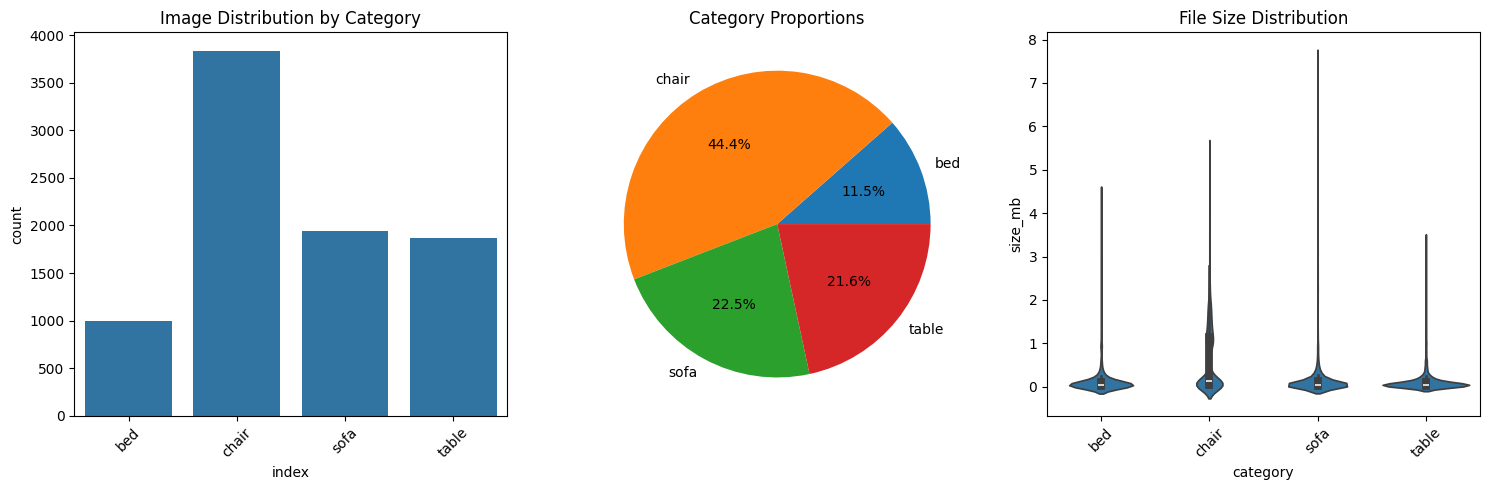

In [14]:
# Visualize image distribution
plt.figure(figsize=(15, 5))

# Bar plot
plt.subplot(131)
sns.barplot(data=df_stats.reset_index(), x='index', y='count')
plt.title('Image Distribution by Category')
plt.xticks(rotation=45)

# Pie chart
plt.subplot(132)
plt.pie(df_stats['count'], labels=df_stats.index, autopct='%1.1f%%')
plt.title('Category Proportions')

# Violin plot for file sizes
plt.subplot(133)
sns.violinplot(data=df_sizes, x='category', y='size_mb')
plt.title('File Size Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


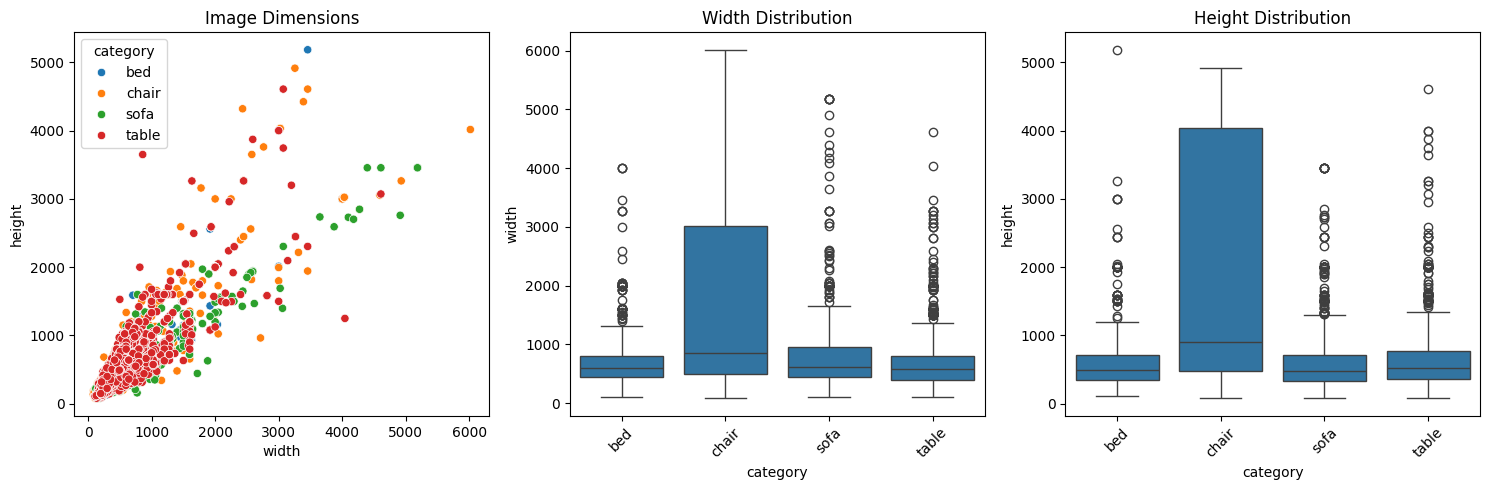

In [15]:
# Visualize image dimensions
plt.figure(figsize=(15, 5))

# Scatter plot of dimensions
plt.subplot(131)
sns.scatterplot(data=df_sizes, x='width', y='height', hue='category')
plt.title('Image Dimensions')

# Box plot of widths
plt.subplot(132)
sns.boxplot(data=df_sizes, x='category', y='width')
plt.title('Width Distribution')
plt.xticks(rotation=45)

# Box plot of heights
plt.subplot(133)
sns.boxplot(data=df_sizes, x='category', y='height')
plt.title('Height Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

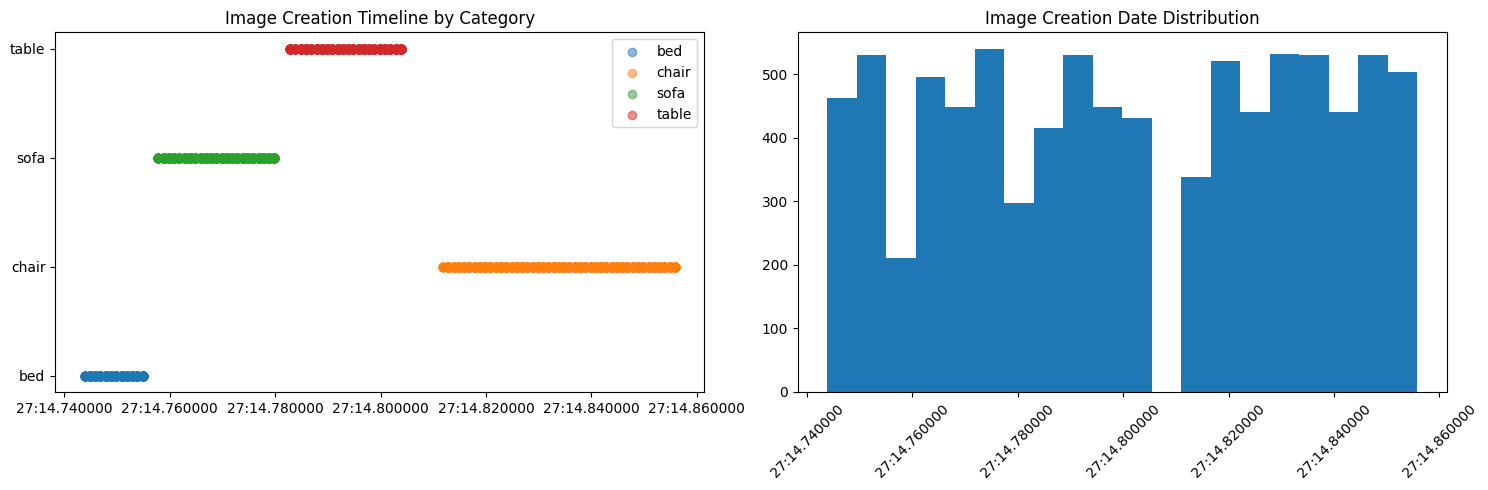

In [16]:
# Visualize creation dates
plt.figure(figsize=(15, 5))

# Timeline of image creation
plt.subplot(121)
for cat in CATEGORIES:
    cat_dates = df_dates[df_dates['category'] == cat]
    plt.scatter(cat_dates['date'], [cat] * len(cat_dates), label=cat, alpha=0.5)
plt.title('Image Creation Timeline by Category')
plt.legend()

# Histogram of creation dates
plt.subplot(122)
plt.hist(df_dates['date'], bins=20)
plt.title('Image Creation Date Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

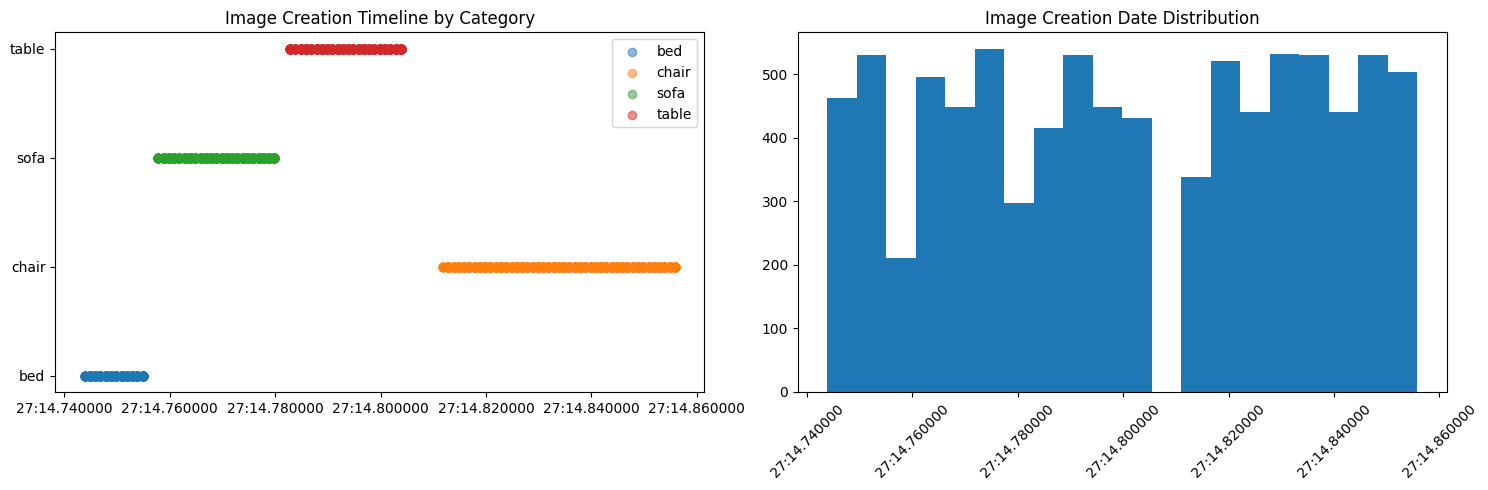

In [17]:
# Visualize creation dates
plt.figure(figsize=(15, 5))

# Timeline of image creation
plt.subplot(121)
for cat in CATEGORIES:
    cat_dates = df_dates[df_dates['category'] == cat]
    plt.scatter(cat_dates['date'], [cat] * len(cat_dates), label=cat, alpha=0.5)
plt.title('Image Creation Timeline by Category')
plt.legend()

# Histogram of creation dates
plt.subplot(122)
plt.hist(df_dates['date'], bins=20)
plt.title('Image Creation Date Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [18]:
# Image processing function
def process_image(image_path):
    """Process an image by resizing, enhancing contrast, and analyzing colors."""
    try:
        img = cv2.imread(str(image_path))
        if img is None:
            return None

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb, (IMAGE_SIZE, IMAGE_SIZE))

        img_lab = cv2.cvtColor(img_resized, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(img_lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        l_clahe = clahe.apply(l)
        img_enhanced = cv2.cvtColor(cv2.merge([l_clahe, a, b]), cv2.COLOR_LAB2RGB)

        color_stats = {
            'mean_rgb': np.mean(img_enhanced, axis=(0, 1)),
            'std_rgb': np.std(img_enhanced, axis=(0, 1)),
            'histogram': [np.histogram(img_enhanced[:, :, i], bins=256)[0] for i in range(3)]
        }

        return img_rgb, img_enhanced, color_stats
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

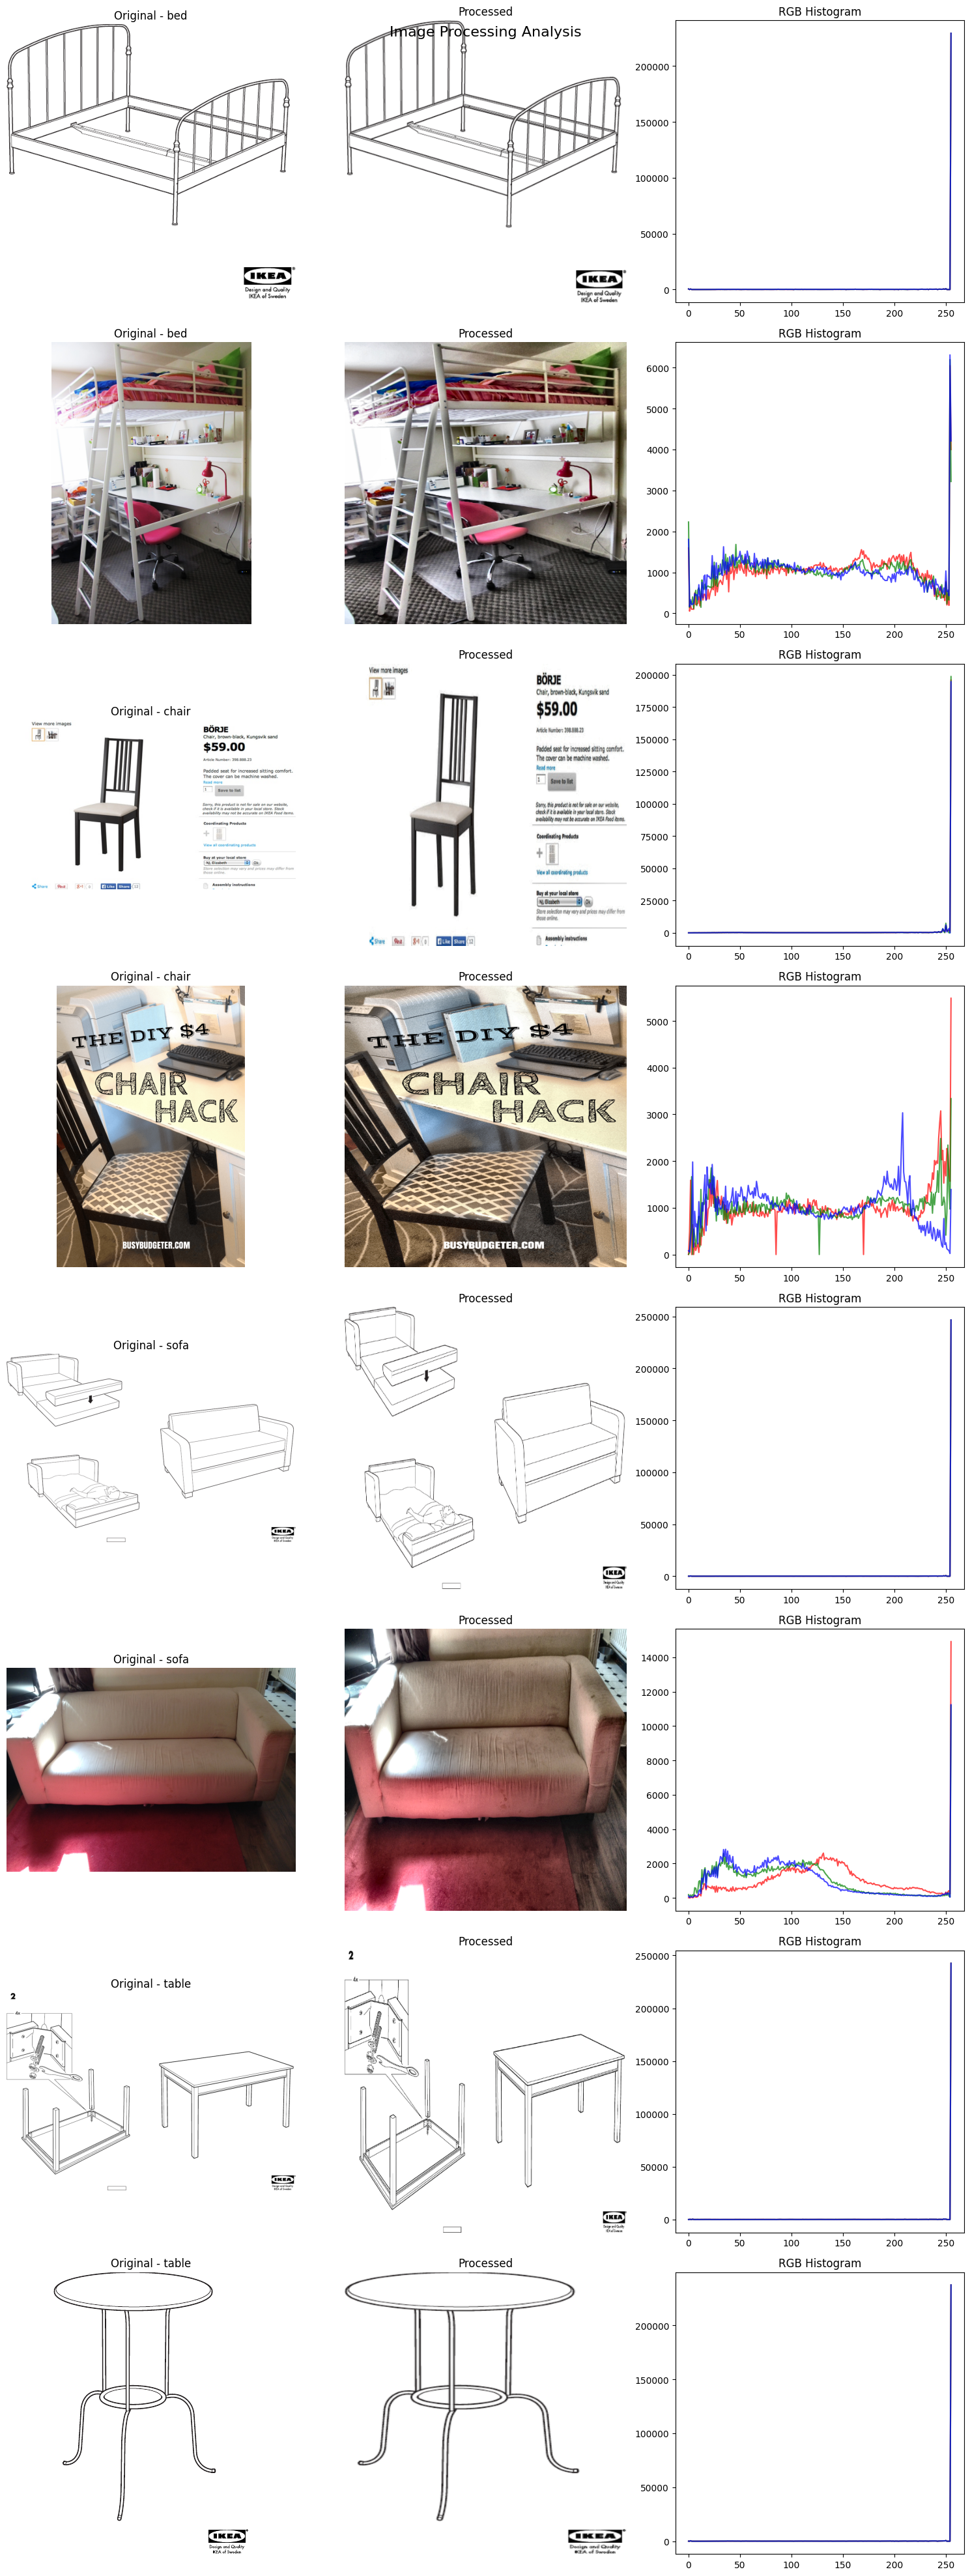

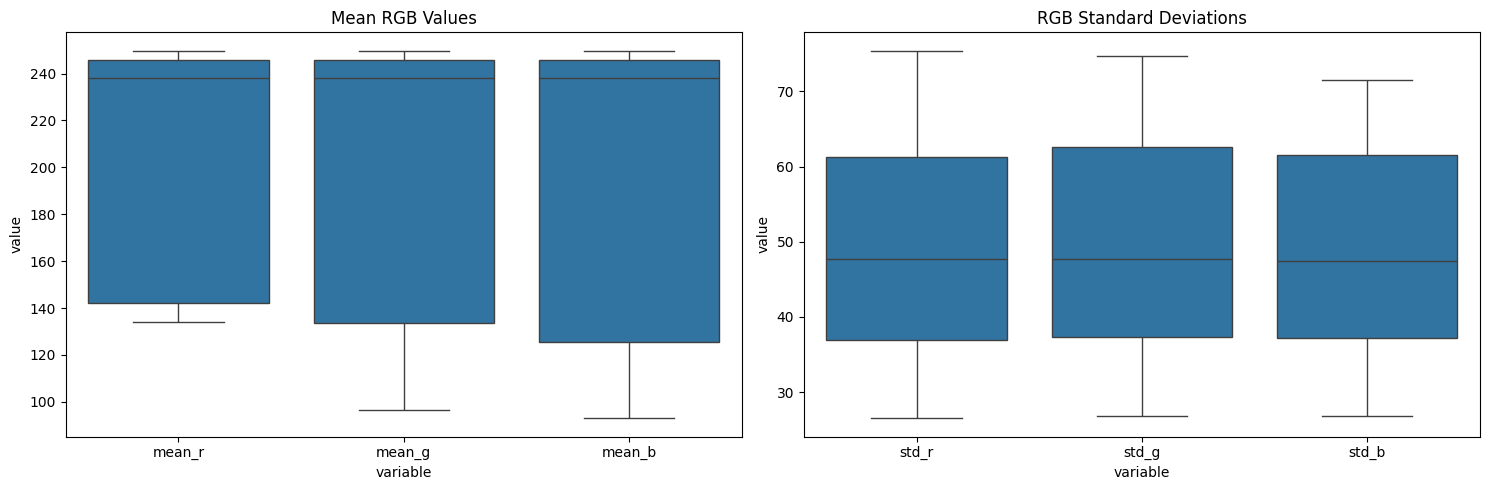

In [19]:
# Process and visualize sample images
sample_images = []
for category in CATEGORIES:
    category_path = RAW_DIR / category
    if category_path.exists():
        images = list(category_path.glob(f"*{FORMATS[0]}"))[:2]
        sample_images.extend(images)

if sample_images:
    n_samples = len(sample_images)
    fig, axes = plt.subplots(n_samples, 3, figsize=(15, 5 * n_samples))
    fig.suptitle("Image Processing Analysis", fontsize=16)

    color_data = []
    for idx, img_path in enumerate(sample_images):
        result = process_image(img_path)
        if result:
            original, enhanced, stats = result

            axes[idx, 0].imshow(original)
            axes[idx, 0].set_title(f"Original - {img_path.parent.name}")
            axes[idx, 0].axis('off')

            axes[idx, 1].imshow(enhanced)
            axes[idx, 1].set_title("Processed")
            axes[idx, 1].axis('off')

            for i, color in enumerate(['r', 'g', 'b']):
                axes[idx, 2].plot(stats['histogram'][i], color=color, alpha=0.7)
            axes[idx, 2].set_title("RGB Histogram")

            color_data.append({
                'category': img_path.parent.name,
                'mean_r': stats['mean_rgb'][0],
                'mean_g': stats['mean_rgb'][1],
                'mean_b': stats['mean_rgb'][2],
                'std_r': stats['std_rgb'][0],
                'std_g': stats['std_rgb'][1],
                'std_b': stats['std_rgb'][2]
            })

    plt.tight_layout()
    plt.show()

    df_colors = pd.DataFrame(color_data)

    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    sns.boxplot(data=pd.melt(df_colors, value_vars=['mean_r', 'mean_g', 'mean_b']), x='variable', y='value')
    plt.title('Mean RGB Values')

    plt.subplot(122)
    sns.boxplot(data=pd.melt(df_colors, value_vars=['std_r', 'std_g', 'std_b']), x='variable', y='value')
    plt.title('RGB Standard Deviations')

    plt.tight_layout()
    plt.show()

In [20]:
# Process all images and save results
all_features = []

for category in CATEGORIES:
    category_path = RAW_DIR / category
    output_category_dir = PROCESSED_DIR / category
    output_category_dir.mkdir(parents=True, exist_ok=True)

    if category_path.exists():
        images = [img for ext in FORMATS for img in category_path.glob(f"*{ext}")]

        for img_path in tqdm(images, desc=f"Processing {category}"):
            result = process_image(img_path)
            if result:
                original, enhanced, stats = result

                output_path = output_category_dir / f"{img_path.stem}.png"
                cv2.imwrite(str(output_path), cv2.cvtColor(enhanced, cv2.COLOR_RGB2BGR))

                features = {
                    'category': category,
                    'path': str(output_path),
                    'mean_r': stats['mean_rgb'][0],
                    'mean_g': stats['mean_rgb'][1],
                    'mean_b': stats['mean_rgb'][2],
                    'std_r': stats['std_rgb'][0],
                    'std_g': stats['std_rgb'][1],
                    'std_b': stats['std_rgb'][2]
                }
                all_features.append(features)


Processing bed:   0%|          | 0/994 [00:00<?, ?it/s]

Processing chair:   0%|          | 0/3838 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Processing sofa:   0%|          | 0/1947 [00:00<?, ?it/s]

Processing table:   0%|          | 0/1870 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
